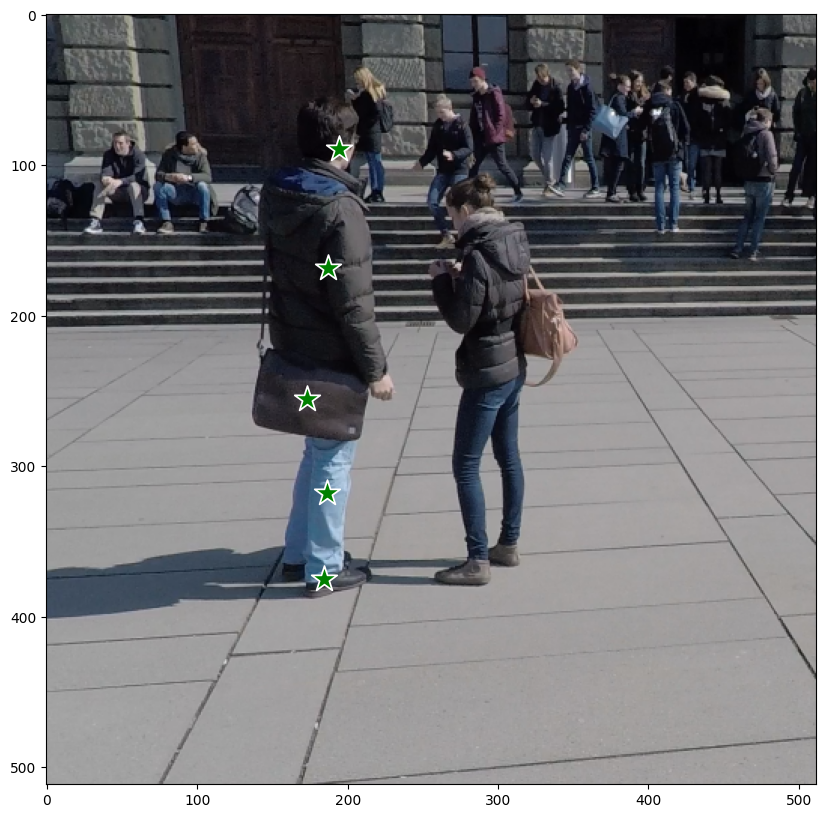

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import json
from tqdm.auto import tqdm
import os

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

def remove_small_regions(
    mask: np.ndarray, area_thresh: float, mode: str
) :
    """
    Removes small disconnected regions and holes in a mask. Returns the
    mask and an indicator of if the mask has been modified.
    """
    import cv2  # type: ignore

    assert mode in ["holes", "islands"]
    correct_holes = mode == "holes"
    working_mask = (correct_holes ^ mask).astype(np.uint8)
    n_labels, regions, stats, _ = cv2.connectedComponentsWithStats(working_mask, 8)
    sizes = stats[:, -1][1:]  # Row 0 is background label
    small_regions = [i + 1 for i, s in enumerate(sizes) if s < area_thresh]
    if len(small_regions) == 0:
        return mask
    fill_labels = [0] + small_regions
    if not correct_holes:
        fill_labels = [i for i in range(n_labels) if i not in fill_labels]
        # If every region is below threshold, keep largest
        if len(fill_labels) == 0:
            fill_labels = [int(np.argmax(sizes)) + 1]
    mask = np.isin(regions, fill_labels)
    return mask

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

id = 1
str_id = f"{id:06d}.png"

image = cv2.imread('wildtrack_processed/images/' + str_id)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)
annotations = json.load(open('annotations.json'))


input_point = np.array(annotations[str_id])
input_label = np.ones_like(input_point[:, 0])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  



def extract_mask(i, predictor, input_point, input_label):
    # 000012
    filename = f"{i:06d}"

    image = cv2.imread(f'wildtrack_processed/images/{filename}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)

    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )

    #SAVE mask to png file
    masks = masks[0]
    
    new_mask = remove_small_regions(masks, 1000, 'islands')
    new_mask = remove_small_regions(new_mask, 500, 'holes')
    
    new_mask = new_mask * 255
    new_mask = new_mask.astype(np.uint8)
    
    if "masks" not in os.listdir("wildtrack_processed"):
        os.mkdir("wildtrack_processed/masks")
    cv2.imwrite(f'wildtrack_processed/masks/{filename}.png', new_mask)



In [16]:

for i in tqdm(range(1, 181)):
    input_point = np.array(annotations[f"{i:06d}.png"])
    input_label = np.ones_like(input_point[:, 0])
    extract_mask(i, predictor, input_point, input_label)


  0%|          | 0/180 [00:00<?, ?it/s]

In [17]:
def cut_image(i):
    filename = f"{i:06d}"
    image = cv2.imread(f'wildtrack_processed/images/{filename}.png')
    mask = cv2.imread(f'wildtrack_processed/masks/{filename}.png')
    result = cv2.bitwise_and(image, mask)
    
    if "cut" not in os.listdir("wildtrack_processed"):
        os.mkdir("wildtrack_processed/cut")
    cv2.imwrite(f'wildtrack_processed/cut/{filename}.png', result)
    
for i in range(1, 181):
    cut_image(i)

In [18]:
!romp --mode=video --calc_smpl --render_mesh -i=C:\Users\Florian\Documents\segment-anything\notebooks\wildtrack_processed\cut -o=C:\Users\Florian\Documents\segment-anything\notebooks\wildtrack_processed\romp_cut

C:\Users\Florian\anaconda3\envs\torch-ngp\lib\site-packages\romp\post_parser.py:34: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_ys = (topk_inds.long() // w).float()
C:\Users\Florian\anaconda3\envs\torch-ngp\lib\site-packages\romp\post_parser.py:39: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_clses = index.long() // K
C:\

Using ROMP v1
ROMP 'forward' executed in 5.4045s, FPS 0.2
ROMP 'forward' executed in 0.0913s, FPS 10.9
ROMP 'forward' executed in 0.0877s, FPS 11.4
ROMP 'forward' executed in 0.0888s, FPS 11.3
ROMP 'forward' executed in 0.0846s, FPS 11.8
ROMP 'forward' executed in 0.0903s, FPS 11.1
ROMP 'forward' executed in 0.0843s, FPS 11.9
ROMP 'forward' executed in 0.0878s, FPS 11.4
ROMP 'forward' executed in 0.0903s, FPS 11.1
ROMP 'forward' executed in 0.0864s, FPS 11.6
ROMP 'forward' executed in 0.0874s, FPS 11.4
ROMP 'forward' executed in 0.0837s, FPS 11.9
ROMP 'forward' executed in 0.0894s, FPS 11.2
ROMP 'forward' executed in 0.0888s, FPS 11.3
ROMP 'forward' executed in 0.0928s, FPS 10.8
ROMP 'forward' executed in 0.0931s, FPS 10.7
ROMP 'forward' executed in 0.0938s, FPS 10.7
ROMP 'forward' executed in 0.0901s, FPS 11.1
ROMP 'forward' executed in 0.0929s, FPS 10.8
ROMP 'forward' executed in 0.0914s, FPS 10.9
ROMP 'forward' executed in 0.1013s, FPS 9.9
ROMP 'forward' executed in 0.0873s, FPS 11.

In [2]:
import pickle
import numpy as np
file = 'C:/Users/Florian/Documents/segment-anything/notebooks/wildtrack_processed/romp_cut/000002.npz'
d = np.load(file, allow_pickle=True)["results"][()]
d.keys()

d


dict_keys(['cam', 'global_orient', 'body_pose', 'smpl_betas', 'smpl_thetas', 'center_preds', 'center_confs', 'cam_trans', 'verts', 'joints', 'pj2d_org'])

In [19]:

import json
import numpy as np
from tqdm.auto import tqdm
def parse_results(i):
    
    filename = f"{i:06d}"
    result = np.load(f'wildtrack_processed/romp_cut/{filename}.npz', allow_pickle=True)['results'][()]
    return result 

output_filename = 'wildtrack_processed/metadata.json'

calib_cam5 = json.load(open('wildtrack_processed/calib_cam5.json'))
K = calib_cam5['K']
R = calib_cam5['R']
T = calib_cam5['T']
int_mat = np.array(K).reshape(3, 3)


def convert_weak_perspective_to_perspective(weak_perspective_camera,focal_length=5000.,img_res=224):
# Convert Weak Perspective Camera [s, tx, ty] to camera translation [tx, ty, tz]
# in 3D given the bounding box size
# This camera translation can be used in a full-perspective projection

    perspective_camera = np.stack(
        [
            weak_perspective_camera[1],
            weak_perspective_camera[2],
            2 * focal_length / (img_res * weak_perspective_camera[0] + 1e-9)
        ],
        axis=-1
    )

    return perspective_camera

extr_mat = np.eye(4)
#extr_mat[:3, :3] = R
#extr_mat[:3, 3] = T

metadata = {}

for i in tqdm(range(1, 181)):
    res_dict = parse_results(i)
    poses = res_dict['smpl_thetas'][0]
    betas = res_dict['smpl_betas'][0]
    
    #cam_intrinsics = int_mat
    cam_intrinsics = np.eye(3)
    H = 512
    W = 512
    FOV = 60
    cam_intrinsics[0,0] = 443.4
    cam_intrinsics[1,1] = 443.4
    cam_intrinsics[0,2] = W/2.
    cam_intrinsics[1,2] = H/2.
    
    rot = res_dict['cam'][0]
    trans = res_dict['cam_trans'][0]
    extr_mat = np.eye(4)
    #extr_mat[:3, :3] = cv2.Rodrigues(rot)[0]
    #T = convert_weak_perspective_to_perspective(trans, focal_length=5000., img_res=512)
    #print(T)
    extr_mat[:3, 3] = trans
    
    #t = res_dict['cam_trans'][0]
    #T = convert_weak_perspective_to_perspective(t, focal_length=5000., img_res=512)
    #extr_mat[:3, 3] = T
    cam_extrinsics = extr_mat 
    
    metadata[f"{i:06d}"] = {
        "poses": poses.tolist(),
        "betas": betas.tolist(),
        "cam_intrinsics": cam_intrinsics.tolist(),
        "cam_extrinsics": cam_extrinsics.tolist()
    }
    
import json
with open(output_filename, 'w') as f:
    json.dump(metadata, f, indent=4)
    
    

  0%|          | 0/180 [00:00<?, ?it/s]